In [1]:
import pandas as pd
import numpy as np

import pickle

import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from importlib import reload 

from sklearn import metrics
import seaborn as sns
sns.set()


from IPython.display import clear_output, display

In [2]:
from preproc_functions import pre_process

In [3]:
from model_functions import SplitModel

## Walk forward for Probit Model

In [4]:
def progress_bar(k, n, incr_txt="Step", bar_len = 10):
   
    bar_char  = u'\u25A5'
    line_char = u'\u21E2' # u'\u2192'  u'\u23AF' u'\u25AD'
    
    places   = int(np.ceil(n/bar_len))
    pct      = k/n
    n_str    = "{:,.0f}".format(n)        
    k_str    = "{:,.0f}".format(k)
    pct_str  = "{:,.0f}%".format(k/n * 100)
    # d_format = "%" + str(places) + "d"
    
    if k == n-1:
        n_bars = bar_len
        n_spaces = 0
        text_txt = "Completed " + n_str + " " + incr_txt + "s."
    else:
        n_bars   = int(np.floor(pct * bar_len))
        n_spaces = bar_len - n_bars
        text_txt = " " + pct_str +  " (" + incr_txt + " " + k_str + " of  " + n_str + ")."

    bar_txt  = "[" + "".ljust(n_bars,bar_char) + "".rjust(n_spaces,line_char) + "]  " 

    clear_output()
    display(bar_txt + text_txt)

In [5]:
def walk_forward_harness(df, start, date_col = 'Date', step_size = 1):     
    predictions = []
    model_list = []
    group_list = []
    
    stats_list = []
    def_percent = []

    labels = []

    ### features for first firm
    first_features = [
        # 'asst_tot_quantile_values', ####
        'financial_leverage_quantile_values',
        'profitability_ratio_quantile_values',
        # 'net_income_growth_quantile_values',
        'quick_ratio_v2_quantile_values',
        # 'sales_growth_quantile_values',
        # 'cash_assets_ratio_quantile_values', ####
        'dscr_quantile_values',
        'roe_quantile_values',
        'cfo_quantile_values',
        # 'ebitda',
        # 'ateco_sector_pd',
        # 'sector_group_pd', ####
        # 'legal_struct_pd',
        'regional_code_pd' ####
    ]


    ### features for recurring firms
    rec_features = [
        # 'asst_tot_quantile_values', ###
        'financial_leverage_quantile_values',
        'profitability_ratio_quantile_values',
        'net_income_growth_quantile_values',
        'quick_ratio_v2_quantile_values',
        'sales_growth_quantile_values',
        # 'cash_assets_ratio_quantile_values',###
        'dscr_quantile_values',
        'roe_quantile_values',
        'cfo_quantile_values',
        # 'ebitda', ###
        # 'ateco_sector_pd',###
        # 'sector_group_pd',###
        # 'legal_struct_pd',###
        'regional_code_pd'
    ]


    with open('custom_bins.pkl', 'rb') as file:
        custom_bins = pickle.load(file)
    
    preproc_params = {
        'quantile_bins' : {},
        'quantile_values' : {},
        'category_pd':{}
    }
    
    # df[date_col] = pd.to_datetime(df[date_col])
    # walk_range = df[date_col].dt.year.unique()
    # walk_range = df['fs_year'].unique()
    df['adjusted_stmt_date']  = df['stmt_date'] + pd.DateOffset(days=150)
    walk_range = df['adjusted_stmt_date'].dt.year.unique()
    
    for i in range(start,len(walk_range), step_size):
        print(stats_list)
        
        train_idx = walk_range[:i]
        test_idx = [walk_range[i]]
        print('Training range:',train_idx)
        print('Test step:',test_idx)

        # print('train',train_idx)
        # print('test',test_idx)
        
        train_data = df[df['adjusted_stmt_date'].dt.year.isin(train_idx)].copy()
        test_data = df[df['adjusted_stmt_date'].dt.year.isin(test_idx)].copy()
        # train_data = df[df['fs_year'].isin(train_idx)].copy()
        # test_data = df[df['fs_year'].isin(test_idx)].copy()
        print(train_data.shape)
        print(test_data.shape)

        train_data_proc , preproc_params = pre_process(train_data, 
                                                       custom_bins=custom_bins, 
                                                       preproc_params = preproc_params,  
                                                       quantiles = 50, 
                                                       days_until_statement = 150)
        # test_data_proc , preproc_params = preprocessor(test_data, preproc_params, new=False)
        test_data_proc , preproc_params = pre_process(test_data, 
                                                     historical_df=train_data_proc, 
                                                     new=False, 
                                                     preproc_params = preproc_params,  
                                                     quantiles = 50, 
                                                     days_until_statement = 150)
        print(train_data_proc['default'].mean())
        print(test_data_proc['default'].mean())

        # print(train_data_proc['is_first_occurrence'].value_counts())
        # print(test_data_proc['is_first_occurrence'].value_counts())

        

        model = SplitModel(algo=smf.probit, first_features=first_features, rec_features=rec_features)
        model.train(train_data_proc)
        
        prediction = model.predict(test_data_proc)
        
        labels += list(test_data_proc['default'].values)
        predictions += list(prediction.values)
        group_list += test_idx * len(prediction)
        
        preds = pd.DataFrame([labels,predictions,group_list]).T
        preds.columns = ['label','prediction','group']
        
        score = metrics.roc_auc_score(y_score=preds['prediction'], y_true=preds['label'])
        
        stats_list.append(score)
        model_list.append(model)

        progress_bar(i, len(walk_range))
    
    predictions = pd.DataFrame([labels,predictions,group_list]).T
    predictions.columns = ['label','prediction','group']
    #predictions.set_index('index', inplace=True)
    
    return(predictions, model_list, stats_list)

In [6]:
modeling_df = pd.read_csv('../data/train.csv', index_col=0)
modeling_df.shape

(1023552, 43)

In [7]:
modeling_df['stmt_date'] = pd.to_datetime(modeling_df['stmt_date'])
modeling_df['def_date'] = pd.to_datetime(modeling_df['def_date'], format="%d/%m/%Y")

In [8]:
### we'll try dropping NA's for now
# modeling_df = modeling_df[~(modeling_df[features].isna().sum(axis=1)>0)].copy()
modeling_df.sort_values('stmt_date', inplace=True)

In [9]:
features_needed = ['id',
                     'stmt_date',
                     'HQ_city',
                     # 'legal_struct',
                     'ateco_sector',
                     'def_date',
                     'fs_year',
                     # 'asst_intang_fixed',
                     # 'asst_tang_fixed',
                     # 'asst_fixed_fin',
                     # 'asst_current',
                     'AR',
                     'cash_and_equiv',
                     'asst_tot',
                     'eqty_tot',
                     # 'eqty_corp_family_tot',
                     # 'liab_lt',
                     # 'liab_lt_emp',
                     # 'debt_bank_st',
                     # 'debt_bank_lt',
                     # 'debt_fin_st',
                     # 'debt_fin_lt',
                     # 'AP_st',
                     # 'AP_lt',
                     'debt_st',
                     'debt_lt',
                     'rev_operating',
                     # 'COGS',
                     'prof_operations',
                     # 'goodwill',
                     # 'inc_financing',
                     'exp_financing',
                     # 'prof_financing',
                     # 'inc_extraord',
                     # 'taxes',
                     'profit',
                     # 'days_rec',
                     'ebitda',
                     # 'roa',
                     # 'roe',
                     # 'wc_net',
                     # 'margin_fin',
                     # 'cf_operations'
                  ]

In [10]:
features_needed

['id',
 'stmt_date',
 'HQ_city',
 'ateco_sector',
 'def_date',
 'fs_year',
 'AR',
 'cash_and_equiv',
 'asst_tot',
 'eqty_tot',
 'debt_st',
 'debt_lt',
 'rev_operating',
 'prof_operations',
 'exp_financing',
 'profit',
 'ebitda']

In [11]:
# modeling_df = modeling_df[features_needed]

In [12]:
modeling_df['def_date'] = pd.to_datetime(modeling_df['def_date'], format="%d/%m/%Y")

In [13]:
predictions, model_list, stats_list = walk_forward_harness(modeling_df,
                                                           date_col = 'stmt_date',
                                                           start = 2, 
                                                           step_size = 1)

'[▥▥▥▥▥▥▥▥▥▥]  Completed 6 Steps.'

In [14]:
# predictions = predictions.dropna()

ROC AUC 0.7933433460956867


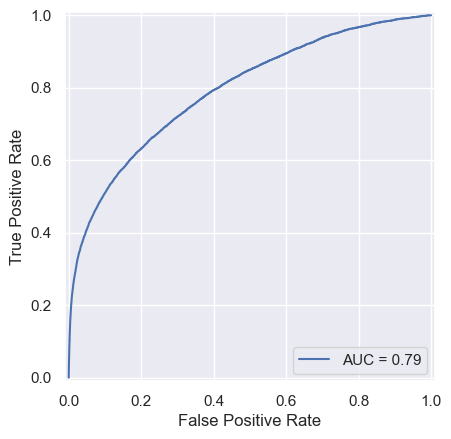

In [15]:
fpr, tpr, thresholds = metrics.roc_curve(predictions['label'], predictions['prediction'])
roc_auc = metrics.auc(fpr, tpr)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
print(f'ROC AUC {roc_auc}')
roc_display.plot()

Text(0, 0.5, 'ROC AUC score (for that test set of size Step)')

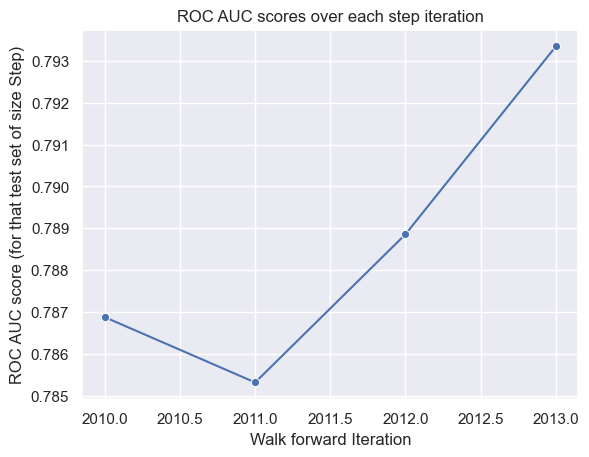

In [16]:
sns.lineplot(x=predictions['group'].unique(), y=stats_list, marker="o")
plt.title('ROC AUC scores over each step iteration')
plt.xlabel('Walk forward Iteration')
plt.ylabel('ROC AUC score (for that test set of size Step)')

In [17]:
default_data_viz = predictions.groupby('group')['label'].mean()

Text(0, 0.5, '% of defaults')

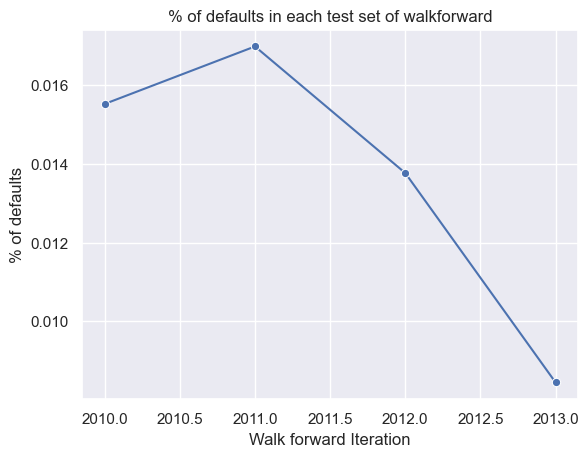

In [18]:
sns.lineplot(x=default_data_viz.index, y=default_data_viz, marker="o")
plt.title('% of defaults in each test set of walkforward')
plt.xlabel('Walk forward Iteration')
plt.ylabel('% of defaults')

Text(0, 0.5, '% of defaults')

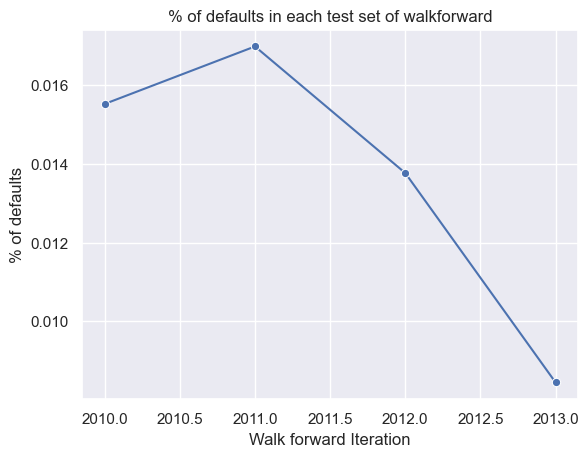

In [19]:
sns.lineplot(x=default_data_viz.index, y=default_data_viz, marker="o")
plt.title('% of defaults in each test set of walkforward')
plt.xlabel('Walk forward Iteration')
plt.ylabel('% of defaults')

In [20]:
stats_list[-1]

np.float64(0.7933433460956867)

In [21]:
last_model = model_list[-1]

In [22]:
print(last_model.rec_fitted_model.summary())

                          Probit Regression Results                           
Dep. Variable:                default   No. Observations:               612920
Model:                         Probit   Df Residuals:                   612910
Method:                           MLE   Df Model:                            9
Date:                Mon, 18 Nov 2024   Pseudo R-squ.:                  0.1814
Time:                        14:48:42   Log-Likelihood:                -38703.
converged:                       True   LL-Null:                       -47280.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -3.3935      0.029   -116.886      0.000      -3.450      -3.337
financial_leverage_quantile_values      2.0190      0.10

In [23]:
print(last_model.first_fitted_model.summary())

                          Probit Regression Results                           
Dep. Variable:                default   No. Observations:               224993
Model:                         Probit   Df Residuals:                   224985
Method:                           MLE   Df Model:                            7
Date:                Mon, 18 Nov 2024   Pseudo R-squ.:                  0.1106
Time:                        14:48:43   Log-Likelihood:                -11350.
converged:                       True   LL-Null:                       -12761.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -3.1261      0.051    -61.857      0.000      -3.225      -3.027
financial_leverage_quantile_values      2.3118      0.20

In [24]:
for year in predictions['group'].unique():
    preds = predictions[predictions['group']==year]['prediction']
    true = predictions[predictions['group']==year]['label']
    print(year, metrics.roc_auc_score(y_true=true, y_score=preds))

2010.0 0.7868725400879455
2011.0 0.7854442621504598
2012.0 0.8028315707046628
2013.0 0.8450728954937419


# XGBoost WF

In [25]:
from xgboost import XGBClassifier

In [93]:
def walk_forward_xgb(df, start, date_col = 'Date', step_size = 1):     
    predictions = []
    model_list = []
    group_list = []
    
    stats_list = []
    def_percent = []

    labels = []

    ### features for first firm
    first_features = [
        # 'asst_tot_quantile_values', ####
        'financial_leverage_quantile_values',
        'profitability_ratio_quantile_values',
        # 'net_income_growth_quantile_values',
        'quick_ratio_v2_quantile_values',
        # 'sales_growth_quantile_values',
        # 'cash_assets_ratio_quantile_values', ####
        'dscr_quantile_values',
        'roe_quantile_values',
        'cfo_quantile_values',
        # 'ebitda',
        # 'ateco_sector_pd',
        # 'sector_group_pd', ####
        # 'legal_struct_pd',
        'regional_code_pd' ####
    ]


    ### features for recurring firms
    rec_features = [
        # 'asst_tot_quantile_values', ###
        'financial_leverage_quantile_values',
        'profitability_ratio_quantile_values',
        'net_income_growth_quantile_values',
        'quick_ratio_v2_quantile_values',
        'sales_growth_quantile_values',
        # 'cash_assets_ratio_quantile_values',###
        'dscr_quantile_values',
        'roe_quantile_values',
        'cfo_quantile_values',
        # 'ebitda', ###
        # 'ateco_sector_pd',###
        # 'sector_group_pd',###
        # 'legal_struct_pd',###
        'regional_code_pd'
    ]


    with open('custom_bins.pkl', 'rb') as file:
        custom_bins = pickle.load(file)
    
    preproc_params = {
        'quantile_bins' : {},
        'quantile_values' : {},
        'category_pd': {}
    }
    
    # df[date_col] = pd.to_datetime(df[date_col])
    # walk_range = df[date_col].dt.year.unique()
    # walk_range = df['fs_year'].unique()
    df['adjusted_stmt_date']  = df['stmt_date'] + pd.DateOffset(days=150)
    walk_range = df['adjusted_stmt_date'].dt.year.unique()
    
    for i in range(start,len(walk_range), step_size):
        print(stats_list)
        
        train_idx = walk_range[:i]
        test_idx = [walk_range[i]]
        print('Training range:',train_idx)
        print('Test step:',test_idx)

        # print('train',train_idx)
        # print('test',test_idx)
        
        train_data = df[df['adjusted_stmt_date'].dt.year.isin(train_idx)].copy()
        test_data = df[df['adjusted_stmt_date'].dt.year.isin(test_idx)].copy()
        # train_data = df[df['fs_year'].isin(train_idx)].copy()
        # test_data = df[df['fs_year'].isin(test_idx)].copy()
        print(train_data.shape)
        print(test_data.shape)

        train_data_proc , preproc_params = pre_process(train_data, 
                                                       custom_bins=custom_bins, 
                                                       preproc_params = preproc_params,  
                                                       quantiles = 50, 
                                                       days_until_statement = 150)
        # test_data_proc , preproc_params = preprocessor(test_data, preproc_params, new=False)
        test_data_proc , preproc_params = pre_process(test_data, 
                                                     historical_df=train_data_proc, 
                                                     new=False, 
                                                     preproc_params = preproc_params,  
                                                     quantiles = 50, 
                                                     days_until_statement = 150)
        print(train_data_proc['default'].mean())
        print(test_data_proc['default'].mean())

        # print(train_data_proc['is_first_occurrence'].value_counts())
        # print(test_data_proc['is_first_occurrence'].value_counts())
        params = {
            "objective": "binary:logistic",
            "eval_metric": "logloss",
            "eta": 0.1,
            "max_depth": 4,
            "min_child_weight": 1,
            "subsample": 0.8,
            "colsample_bytree": 0.8,
            "gamma": 0,
            "alpha": 0.1,
            "lambda": .1,
            "n_estimators":250
         }
        
        rec_bst = XGBClassifier(**params)
        first_bst = XGBClassifier(**params)

        rec_train_data = train_data_proc[train_data_proc['is_first_occurrence']==0]
        first_train_data = train_data_proc[train_data_proc['is_first_occurrence']==1]
        
        rec_test_data = test_data_proc[test_data_proc['is_first_occurrence']==0]
        first_test_data = test_data_proc[test_data_proc['is_first_occurrence']==1]

        
        rec_bst = rec_bst.fit(X=rec_train_data[rec_features], 
                   y=rec_train_data['default'])

        first_bst = first_bst.fit(X=first_train_data[first_features], 
                           y=first_train_data['default'])

        
        rec_preds = rec_bst.predict_proba(rec_test_data[rec_features])[:,1]
        rec_test_results = rec_test_data[['default']].copy()
        rec_test_results['predictions'] = rec_preds
        
        first_preds = first_bst.predict_proba(first_test_data[first_features])[:,1]
        first_test_results = first_test_data[['default']].copy()
        first_test_results['predictions'] = first_preds

        prediction = pd.concat([rec_test_results,first_test_results]).reindex(test_data_proc.index)

        model = (rec_bst,first_bst)
        
        labels += list(prediction['default'].values)
        predictions += list(prediction['predictions'].values)
        group_list += test_idx * len(prediction)
        
        preds = pd.DataFrame([labels,predictions,group_list]).T
        preds.columns = ['label','prediction','group']
        
        score = metrics.roc_auc_score(y_score=preds['prediction'], y_true=preds['label'])
        
        stats_list.append(score)
        model_list.append(model)

        progress_bar(i, len(walk_range))
    
    predictions = pd.DataFrame([labels,predictions,group_list]).T
    predictions.columns = ['label','prediction','group']
    #predictions.set_index('index', inplace=True)
    
    return(predictions, model_list, stats_list)

In [94]:
xgb_predictions, xgb_model_list, xgb_stats_list = walk_forward_xgb(modeling_df,
                                                           date_col = 'stmt_date',
                                                           start = 2, 
                                                           step_size = 1)

'[▥▥▥▥▥▥▥▥▥▥]  Completed 6 Steps.'

ROC AUC 0.8193583739453076


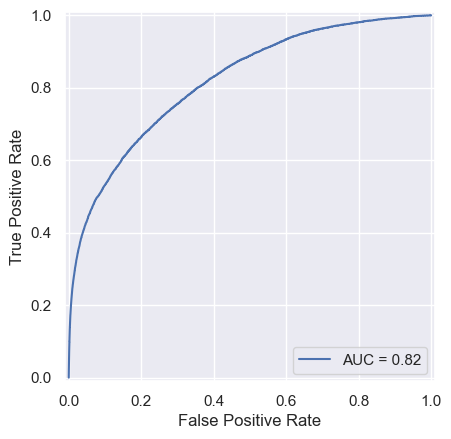

In [95]:
fpr, tpr, thresholds = metrics.roc_curve(xgb_predictions['label'], xgb_predictions['prediction'])
roc_auc = metrics.auc(fpr, tpr)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
print(f'ROC AUC {roc_auc}')
roc_display.plot()

Text(0, 0.5, 'ROC AUC score (for that test set of size Step)')

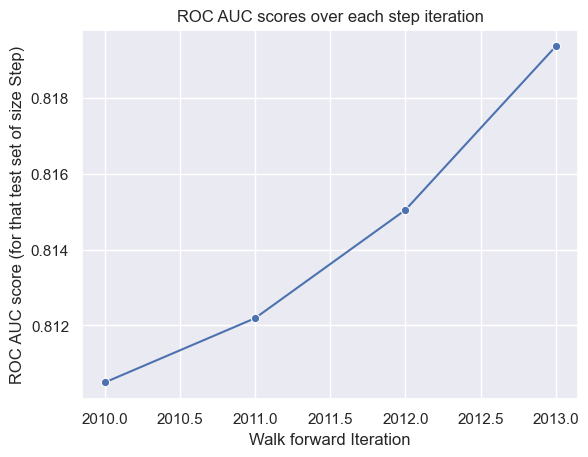

In [96]:
sns.lineplot(x=xgb_predictions['group'].unique(), y=xgb_stats_list, marker="o")
plt.title('ROC AUC scores over each step iteration')
plt.xlabel('Walk forward Iteration')
plt.ylabel('ROC AUC score (for that test set of size Step)')

In [97]:
default_data_viz = xgb_predictions.groupby('group')['label'].mean()

Text(0, 0.5, '% of defaults')

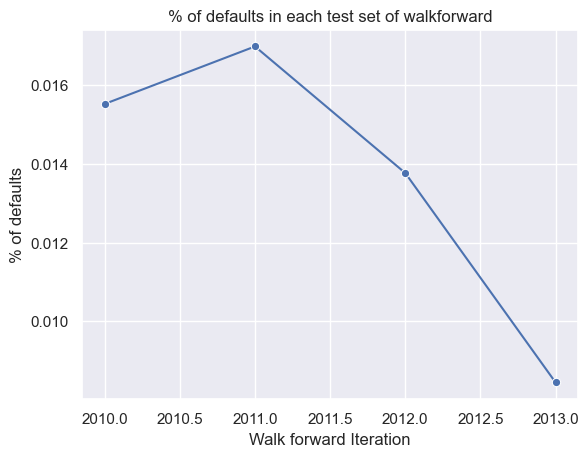

In [98]:
sns.lineplot(x=default_data_viz.index, y=default_data_viz, marker="o")
plt.title('% of defaults in each test set of walkforward')
plt.xlabel('Walk forward Iteration')
plt.ylabel('% of defaults')

In [99]:
xgb_stats_list[-1]

np.float64(0.8193583739453076)

In [100]:
last_model = xgb_model_list[-1]

In [101]:
for year in xgb_predictions['group'].unique():
    preds = xgb_predictions[xgb_predictions['group']==year]['prediction']
    true = xgb_predictions[xgb_predictions['group']==year]['label']
    print(year, metrics.roc_auc_score(y_true=true, y_score=preds))

2010.0 0.8104923581705601
2011.0 0.814171748715598
2012.0 0.825776050716642
2013.0 0.8657406548925941


# XGBoost WF - single model

In [102]:
from xgboost import XGBClassifier

In [107]:
def walk_forward_xgb_2(df, start, date_col = 'Date', step_size = 1):     
    predictions = []
    model_list = []
    group_list = []
    
    stats_list = []
    def_percent = []

    labels = []

    ### features for first firm
    first_features = [
        # 'asst_tot_quantile_values', ####
        'financial_leverage_quantile_values',
        'profitability_ratio_quantile_values',
        # 'net_income_growth_quantile_values',
        'quick_ratio_v2_quantile_values',
        # 'sales_growth_quantile_values',
        # 'cash_assets_ratio_quantile_values', ####
        'dscr_quantile_values',
        'roe_quantile_values',
        'cfo_quantile_values',
        # 'ebitda',
        # 'ateco_sector_pd',
        # 'sector_group_pd', ####
        # 'legal_struct_pd',
        'regional_code_pd' ####
    ]


    with open('custom_bins.pkl', 'rb') as file:
        custom_bins = pickle.load(file)
    
    preproc_params = {
        'quantile_bins' : {},
        'quantile_values' : {},
        'category_pd': {}
    }
    
    # df[date_col] = pd.to_datetime(df[date_col])
    # walk_range = df[date_col].dt.year.unique()
    # walk_range = df['fs_year'].unique()
    df['adjusted_stmt_date']  = df['stmt_date'] + pd.DateOffset(days=150)
    walk_range = df['adjusted_stmt_date'].dt.year.unique()
    
    for i in range(start,len(walk_range), step_size):
        print(stats_list)
        
        train_idx = walk_range[:i]
        test_idx = [walk_range[i]]
        print('Training range:',train_idx)
        print('Test step:',test_idx)

        # print('train',train_idx)
        # print('test',test_idx)
        
        train_data = df[df['adjusted_stmt_date'].dt.year.isin(train_idx)].copy()
        test_data = df[df['adjusted_stmt_date'].dt.year.isin(test_idx)].copy()
        # train_data = df[df['fs_year'].isin(train_idx)].copy()
        # test_data = df[df['fs_year'].isin(test_idx)].copy()
        print(train_data.shape)
        print(test_data.shape)

        train_data_proc , preproc_params = pre_process(train_data, 
                                                       custom_bins=custom_bins, 
                                                       preproc_params = preproc_params,  
                                                       quantiles = 50, 
                                                       days_until_statement = 150)
        # test_data_proc , preproc_params = preprocessor(test_data, preproc_params, new=False)
        test_data_proc , preproc_params = pre_process(test_data, 
                                                     historical_df=train_data_proc, 
                                                     new=False, 
                                                     preproc_params = preproc_params,  
                                                     quantiles = 50, 
                                                     days_until_statement = 150)
        print(train_data_proc['default'].mean())
        print(test_data_proc['default'].mean())

        # print(train_data_proc['is_first_occurrence'].value_counts())
        # print(test_data_proc['is_first_occurrence'].value_counts())
        params = {
            "objective": "binary:logistic",
            "eval_metric": "logloss",
            "eta": 0.1,
            "max_depth": 4,
            "min_child_weight": 1,
            "subsample": 0.8,
            "colsample_bytree": 0.8,
            "gamma": 0,
            "alpha": 0.1,
            "lambda": .1,
            "n_estimators":250
         }
        
        
        first_bst = XGBClassifier(**params)

        first_bst = first_bst.fit(X=train_data_proc[first_features], 
                           y=train_data_proc['default'])
        
        
        first_preds = first_bst.predict_proba(test_data_proc[first_features])[:,1]
        first_test_results = test_data_proc[['default']].copy()
        first_test_results['predictions'] = first_preds

        prediction = first_test_results

        model = first_bst
        
        labels += list(prediction['default'].values)
        predictions += list(prediction['predictions'].values)
        group_list += test_idx * len(prediction)
        
        preds = pd.DataFrame([labels,predictions,group_list]).T
        preds.columns = ['label','prediction','group']
        
        score = metrics.roc_auc_score(y_score=preds['prediction'], y_true=preds['label'])
        
        stats_list.append(score)
        model_list.append(model)

        progress_bar(i, len(walk_range))
    
    predictions = pd.DataFrame([labels,predictions,group_list]).T
    predictions.columns = ['label','prediction','group']
    #predictions.set_index('index', inplace=True)
    
    return(predictions, model_list, stats_list)

In [108]:
xgb_2_predictions, xgb_2_model_list, xgb_2_stats_list = walk_forward_xgb_2(modeling_df,
                                                           date_col = 'stmt_date',
                                                           start = 2, 
                                                           step_size = 1)

'[▥▥▥▥▥▥▥▥▥▥]  Completed 6 Steps.'

ROC AUC 0.8160998308875073


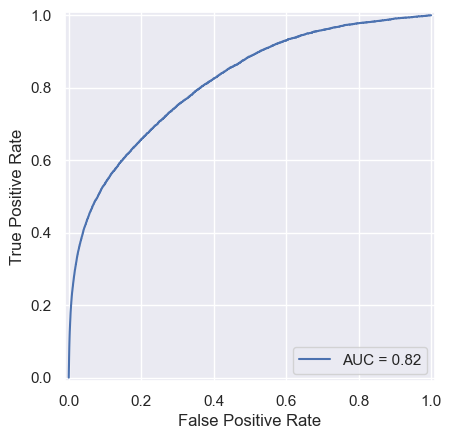

In [116]:
fpr, tpr, thresholds = metrics.roc_curve(xgb_2_predictions['label'], xgb_2_predictions['prediction'])
roc_auc = metrics.auc(fpr, tpr)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
print(f'ROC AUC {roc_auc}')
roc_display.plot()

Text(0, 0.5, 'ROC AUC score (for that test set of size Step)')

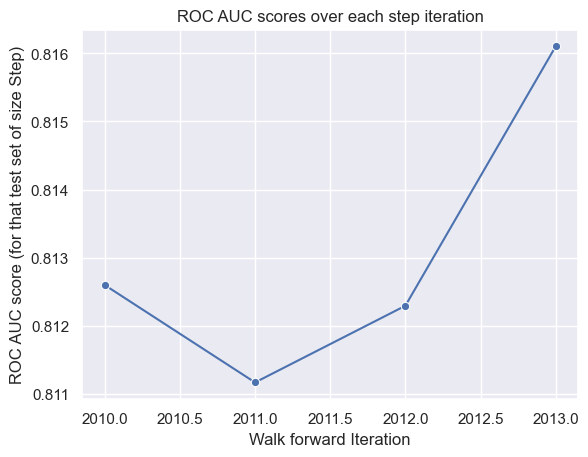

In [117]:
sns.lineplot(x=xgb_2_predictions['group'].unique(), y=xgb_2_stats_list, marker="o")
plt.title('ROC AUC scores over each step iteration')
plt.xlabel('Walk forward Iteration')
plt.ylabel('ROC AUC score (for that test set of size Step)')

In [118]:
default_data_viz = xgb_2_predictions.groupby('group')['label'].mean()

Text(0, 0.5, '% of defaults')

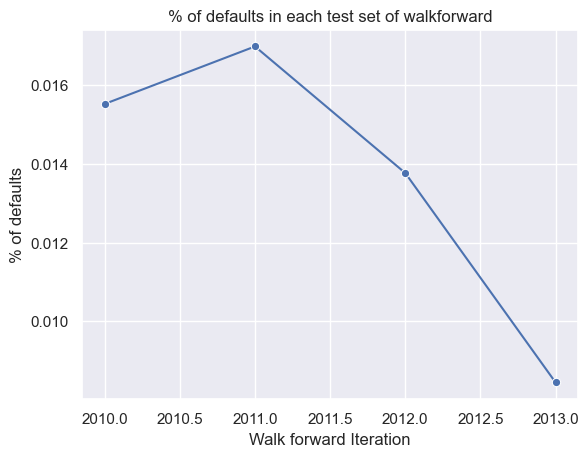

In [119]:
sns.lineplot(x=default_data_viz.index, y=default_data_viz, marker="o")
plt.title('% of defaults in each test set of walkforward')
plt.xlabel('Walk forward Iteration')
plt.ylabel('% of defaults')

In [120]:
xgb_2_stats_list[-1]

np.float64(0.8160998308875073)

In [121]:
last_model = xgb_2_model_list[-1]

In [122]:
for year in xgb_2_predictions['group'].unique():
    preds = xgb_2_predictions[xgb_2_predictions['group']==year]['prediction']
    true = xgb_2_predictions[xgb_2_predictions['group']==year]['label']
    print(year, metrics.roc_auc_score(y_true=true, y_score=preds))

2010.0 0.8125998111673491
2011.0 0.8092419206991319
2012.0 0.822230305028639
2013.0 0.8619873841244046


# RF WF

In [35]:
from sklearn.ensemble import RandomForestClassifier

In [36]:
def walk_forward_rf(df, start, date_col = 'Date', step_size = 1):     
    predictions = []
    model_list = []
    group_list = []
    
    stats_list = []
    def_percent = []

    labels = []

    ### features for first firm
    first_features = [
        # 'asst_tot_quantile_values', ####
        'financial_leverage_quantile_values',
        'profitability_ratio_quantile_values',
        # 'net_income_growth_quantile_values',
        'quick_ratio_v2_quantile_values',
        # 'sales_growth_quantile_values',
        # 'cash_assets_ratio_quantile_values', ####
        'dscr_quantile_values',
        'roe_quantile_values',
        'cfo_quantile_values',
        # 'ebitda',
        # 'ateco_sector_pd',
        # 'sector_group_pd', ####
        # 'legal_struct_pd',
        'regional_code_pd' ####
    ]


    ### features for recurring firms
    rec_features = [
        # 'asst_tot_quantile_values', ###
        'financial_leverage_quantile_values',
        'profitability_ratio_quantile_values',
        'net_income_growth_quantile_values',
        'quick_ratio_v2_quantile_values',
        'sales_growth_quantile_values',
        # 'cash_assets_ratio_quantile_values',###
        'dscr_quantile_values',
        'roe_quantile_values',
        'cfo_quantile_values',
        # 'ebitda', ###
        # 'ateco_sector_pd',###
        # 'sector_group_pd',###
        # 'legal_struct_pd',###
        'regional_code_pd'
    ]


    with open('custom_bins.pkl', 'rb') as file:
        custom_bins = pickle.load(file)
    
    preproc_params = {
        'quantile_bins' : {},
        'quantile_values' : {},
        'category_pd': {}
    }
    
    # df[date_col] = pd.to_datetime(df[date_col])
    # walk_range = df[date_col].dt.year.unique()
    # walk_range = df['fs_year'].unique()
    df['adjusted_stmt_date']  = df['stmt_date'] + pd.DateOffset(days=150)
    walk_range = df['adjusted_stmt_date'].dt.year.unique()
    
    for i in range(start,len(walk_range), step_size):
        print(stats_list)
        
        train_idx = walk_range[:i]
        test_idx = [walk_range[i]]
        print('Training range:',train_idx)
        print('Test step:',test_idx)

        # print('train',train_idx)
        # print('test',test_idx)
        
        train_data = df[df['adjusted_stmt_date'].dt.year.isin(train_idx)].copy()
        test_data = df[df['adjusted_stmt_date'].dt.year.isin(test_idx)].copy()
        # train_data = df[df['fs_year'].isin(train_idx)].copy()
        # test_data = df[df['fs_year'].isin(test_idx)].copy()
        print(train_data.shape)
        print(test_data.shape)

        train_data_proc , preproc_params = pre_process(train_data, 
                                                       custom_bins=custom_bins, 
                                                       preproc_params = preproc_params,  
                                                       quantiles = 50, 
                                                       days_until_statement = 150)
        # test_data_proc , preproc_params = preprocessor(test_data, preproc_params, new=False)
        test_data_proc , preproc_params = pre_process(test_data, 
                                                     historical_df=train_data_proc, 
                                                     new=False, 
                                                     preproc_params = preproc_params,  
                                                     quantiles = 50, 
                                                     days_until_statement = 150)
        print(train_data_proc['default'].mean())
        print(test_data_proc['default'].mean())

        # print(train_data_proc['is_first_occurrence'].value_counts())
        # print(test_data_proc['is_first_occurrence'].value_counts())
        params = {
            "max_depth": 5,
            "n_estimators":250
         }
        
        rec_bst = RandomForestClassifier(**params)
        first_bst = RandomForestClassifier(**params)

        rec_train_data = train_data_proc[train_data_proc['is_first_occurrence']==0]
        first_train_data = train_data_proc[train_data_proc['is_first_occurrence']==1]
        
        rec_test_data = test_data_proc[test_data_proc['is_first_occurrence']==0]
        first_test_data = test_data_proc[test_data_proc['is_first_occurrence']==1]

        
        rec_bst = rec_bst.fit(X=rec_train_data[rec_features], 
                   y=rec_train_data['default'])

        first_bst = first_bst.fit(X=first_train_data[first_features], 
                           y=first_train_data['default'])

        
        rec_preds = rec_bst.predict_proba(rec_test_data[rec_features])[:,1]
        rec_test_results = rec_test_data[['default']].copy()
        rec_test_results['predictions'] = rec_preds
        
        first_preds = first_bst.predict_proba(first_test_data[first_features])[:,1]
        first_test_results = first_test_data[['default']].copy()
        first_test_results['predictions'] = first_preds

        prediction = pd.concat([rec_test_results,first_test_results]).reindex(test_data_proc.index)

        model = (rec_bst,first_bst)
        
        labels += list(prediction['default'].values)
        predictions += list(prediction['predictions'].values)
        group_list += test_idx * len(prediction)
        
        preds = pd.DataFrame([labels,predictions,group_list]).T
        preds.columns = ['label','prediction','group']
        
        score = metrics.roc_auc_score(y_score=preds['prediction'], y_true=preds['label'])
        
        stats_list.append(score)
        model_list.append(model)

        progress_bar(i, len(walk_range))
    
    predictions = pd.DataFrame([labels,predictions,group_list]).T
    predictions.columns = ['label','prediction','group']
    #predictions.set_index('index', inplace=True)
    
    return(predictions, model_list, stats_list)

In [37]:
rf_predictions, rf_model_list, rf_stats_list = walk_forward_rf(modeling_df,
                                                           date_col = 'stmt_date',
                                                           start = 2, 
                                                           step_size = 1)

'[▥▥▥▥▥▥▥▥▥▥]  Completed 6 Steps.'

ROC AUC 0.8097295555710724


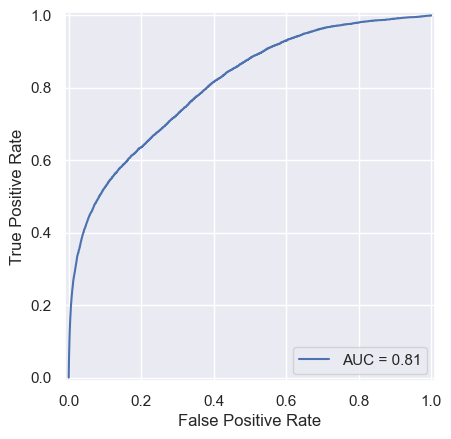

In [38]:
fpr, tpr, thresholds = metrics.roc_curve(rf_predictions['label'], rf_predictions['prediction'])
roc_auc = metrics.auc(fpr, tpr)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
print(f'ROC AUC {roc_auc}')
roc_display.plot()

Text(0, 0.5, 'ROC AUC score (for that test set of size Step)')

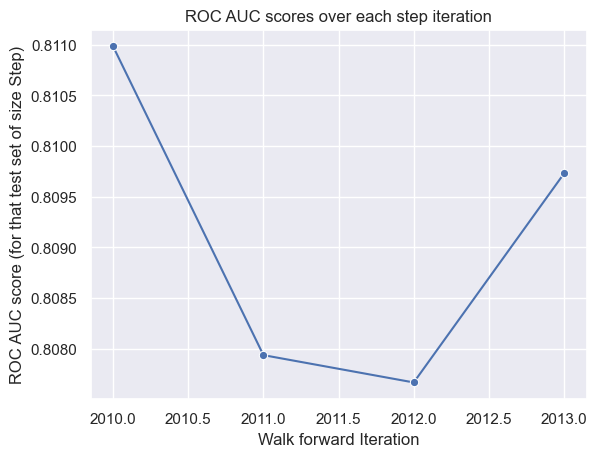

In [39]:
sns.lineplot(x=rf_predictions['group'].unique(), y=rf_stats_list, marker="o")
plt.title('ROC AUC scores over each step iteration')
plt.xlabel('Walk forward Iteration')
plt.ylabel('ROC AUC score (for that test set of size Step)')

In [40]:
default_data_viz = rf_predictions.groupby('group')['label'].mean()

Text(0, 0.5, '% of defaults')

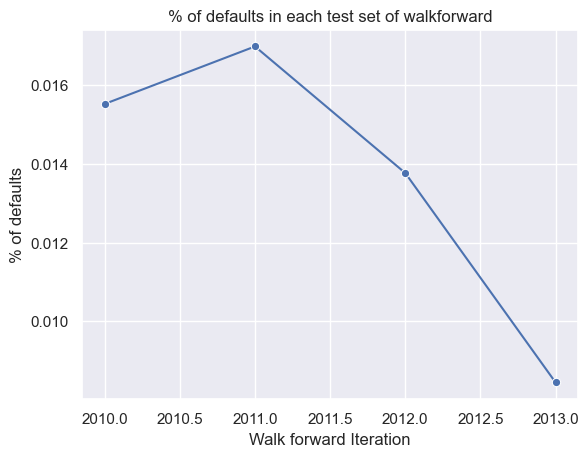

In [41]:
sns.lineplot(x=default_data_viz.index, y=default_data_viz, marker="o")
plt.title('% of defaults in each test set of walkforward')
plt.xlabel('Walk forward Iteration')
plt.ylabel('% of defaults')

In [42]:
rf_stats_list[-1]

np.float64(0.8097295555710724)

In [43]:
last_model = rf_model_list[-1]

In [44]:
for year in rf_predictions['group'].unique():
    preds = rf_predictions[rf_predictions['group']==year]['prediction']
    true = rf_predictions[rf_predictions['group']==year]['label']
    print(year, metrics.roc_auc_score(y_true=true, y_score=preds))

2010.0 0.810983013266641
2011.0 0.8051441913797848
2012.0 0.8160021630061919
2013.0 0.8524472058613364


# Naive Baseline WF

In [45]:
def walk_forward_naive(df, start, date_col = 'Date', step_size = 1):     
    predictions = []
    model_list = []
    group_list = []
    
    stats_list = []
    def_percent = []

    labels = []

    ### features for first firm
    first_features = [
        'ateco_sector_pd',
        'sector_group_pd', ####
        'legal_struct_pd',
        'regional_code_pd' ####
    ]


    with open('custom_bins.pkl', 'rb') as file:
        custom_bins = pickle.load(file)
    
    preproc_params = {
        'quantile_bins' : {},
        'quantile_values' : {},
        'category_pd':{}
    }
    
    # df[date_col] = pd.to_datetime(df[date_col])
    # walk_range = df[date_col].dt.year.unique()
    walk_range = df['fs_year'].unique()
    df['adjusted_stmt_date']  = df['stmt_date'] + pd.DateOffset(days=150)
    walk_range = df['adjusted_stmt_date'].dt.year.unique()
    
    for i in range(start,len(walk_range), step_size):
        print(stats_list)
        
        train_idx = walk_range[:i]
        test_idx = [walk_range[i]]
        print('Training range:',train_idx)
        print('Test step:',test_idx)

        # print('train',train_idx)
        # print('test',test_idx)
        
        train_data = df[df['adjusted_stmt_date'].dt.year.isin(train_idx)].copy()
        test_data = df[df['adjusted_stmt_date'].dt.year.isin(test_idx)].copy()
        # train_data = df[df['fs_year'].isin(train_idx)].copy()
        # test_data = df[df['fs_year'].isin(test_idx)].copy()
        print(train_data.shape)
        print(test_data.shape)

        train_data_proc , preproc_params = pre_process(train_data, 
                                                       custom_bins=custom_bins, 
                                                       preproc_params = preproc_params,  
                                                       quantiles = 50, 
                                                       days_until_statement = 150)
        # test_data_proc , preproc_params = preprocessor(test_data, preproc_params, new=False)
        test_data_proc , preproc_params = pre_process(test_data, 
                                                     historical_df=train_data_proc, 
                                                     new=False, 
                                                     preproc_params = preproc_params,  
                                                     quantiles = 50, 
                                                     days_until_statement = 150)
        print(train_data_proc['default'].mean())
        print(test_data_proc['default'].mean())

        # print(train_data_proc['is_first_occurrence'].value_counts())
        # print(test_data_proc['is_first_occurrence'].value_counts())

        first_formula = 'default ~ '+' + '.join(first_features)
        
        first_model = smf.probit(first_formula, data = train_data_proc)
        model = first_model.fit()
        
        prediction = model.predict(test_data_proc)
        
        labels += list(test_data_proc['default'].values)
        predictions += list(prediction.values)
        group_list += test_idx * len(prediction)
        
        preds = pd.DataFrame([labels,predictions,group_list]).T
        preds.columns = ['label','prediction','group']
        
        score = metrics.roc_auc_score(y_score=preds['prediction'], y_true=preds['label'])
        
        stats_list.append(score)
        model_list.append(model)

        progress_bar(i, len(walk_range))
    
    predictions = pd.DataFrame([labels,predictions,group_list]).T
    predictions.columns = ['label','prediction','group']
    #predictions.set_index('index', inplace=True)
    
    return(predictions, model_list, stats_list)

In [46]:
naive_predictions, naive_model_list, naive_stats_list = walk_forward_naive(modeling_df,
                                                           date_col = 'stmt_date',
                                                           start = 2, 
                                                           step_size = 1)

'[▥▥▥▥▥▥▥▥▥▥]  Completed 6 Steps.'

ROC AUC 0.5921068196405495


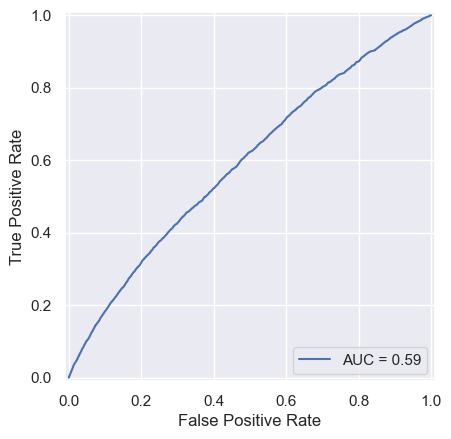

In [47]:
fpr, tpr, thresholds = metrics.roc_curve(naive_predictions['label'], naive_predictions['prediction'])
roc_auc = metrics.auc(fpr, tpr)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
print(f'ROC AUC {roc_auc}')
roc_display.plot()

In [48]:
naive_predictions['group'].unique()

array([2010., 2011., 2012., 2013.])

In [49]:
naive_stats_list

[np.float64(0.5973441930415884),
 np.float64(0.6005342554419744),
 np.float64(0.5962103385595747),
 np.float64(0.5921068196405495)]

Text(0, 0.5, 'ROC AUC score (for that test set of size Step)')

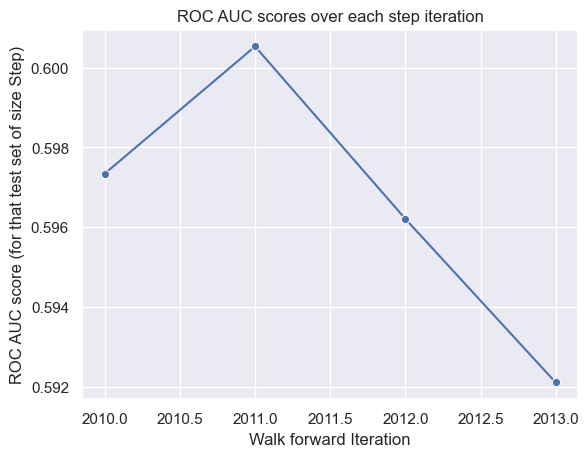

In [50]:
sns.lineplot(x=naive_predictions['group'].unique(), y=naive_stats_list, marker="o")
plt.title('ROC AUC scores over each step iteration')
plt.xlabel('Walk forward Iteration')
plt.ylabel('ROC AUC score (for that test set of size Step)')

In [51]:
default_data_viz = naive_predictions.groupby('group')['label'].mean()

Text(0, 0.5, '% of defaults')

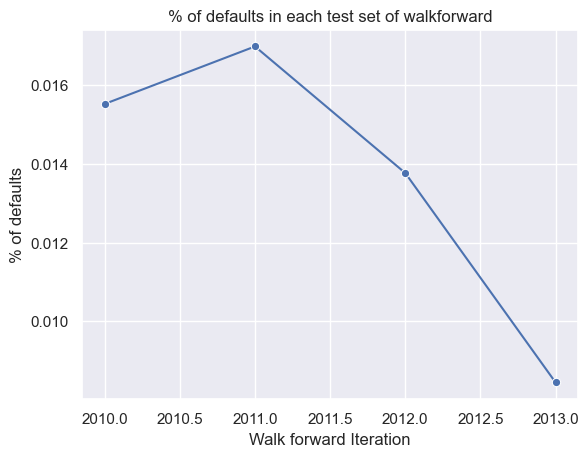

In [52]:
sns.lineplot(x=default_data_viz.index, y=default_data_viz, marker="o")
plt.title('% of defaults in each test set of walkforward')
plt.xlabel('Walk forward Iteration')
plt.ylabel('% of defaults')

In [53]:
naive_stats_list[-1]

np.float64(0.5921068196405495)

In [54]:
last_model = naive_model_list[-1]

In [55]:
for year in naive_predictions['group'].unique():
    preds = naive_predictions[naive_predictions['group']==year]['prediction']
    true = naive_predictions[naive_predictions['group']==year]['label']
    print(year, metrics.roc_auc_score(y_true=true, y_score=preds))

2010.0 0.5973441930415884
2011.0 0.6042784161118372
2012.0 0.6176154424795454
2013.0 0.633522174964319


# Comparison of models

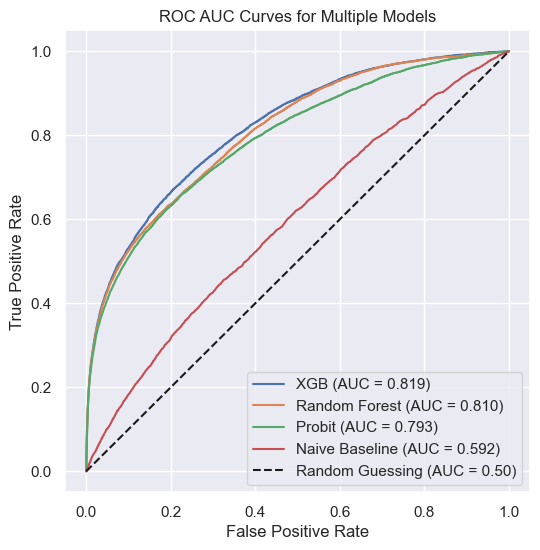

In [62]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming df1, df2, and df3 are your three DataFrames with true labels and predictions
dataframes = [xgb_predictions,rf_predictions, predictions ,naive_predictions]
labels = [ "XGB", "Random Forest","Probit", "Naive Baseline"]

plt.figure(figsize=(6, 6))

for i, df in enumerate(dataframes):
    # Replace 'true_labels' and 'predictions' with the actual column names in your DataFrames
    fpr, tpr, _ = roc_curve(df['label'], df['prediction'])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve for the current model
    plt.plot(fpr, tpr, label=f"{labels[i]} (AUC = {roc_auc:.3f})")

# Plot the random guessing line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing (AUC = 0.50)')

# Labels, title, and legend
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC AUC Curves for Multiple Models")
plt.legend(loc="lower right")
plt.savefig('model_comparison.png')
plt.show()

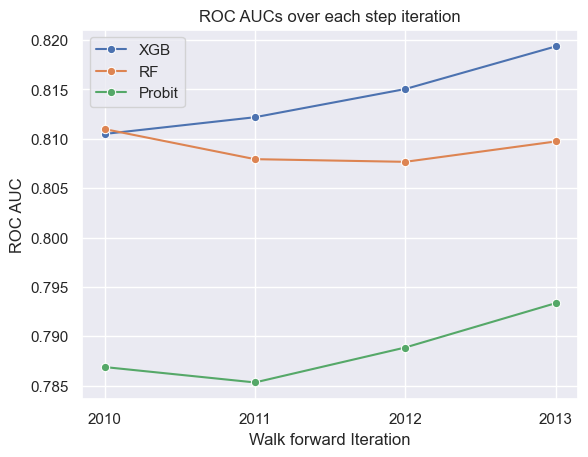

In [79]:
sns.lineplot(x=xgb_predictions['group'].unique().astype(int).astype(str), y=xgb_stats_list, marker="o",label='XGB')
sns.lineplot(x=rf_predictions['group'].unique().astype(int).astype(str), y=rf_stats_list, marker="o",label='RF')
sns.lineplot(x=predictions['group'].unique().astype(int).astype(str), y=stats_list, marker="o",label='Probit')
plt.title('ROC AUCs over each step iteration')
plt.xlabel('Walk forward Iteration')
plt.ylabel('ROC AUC')
plt.savefig('wf_results.png')
plt.show()

In [67]:
predictions['group'].unique().astype(int)

array([2010, 2011, 2012, 2013])

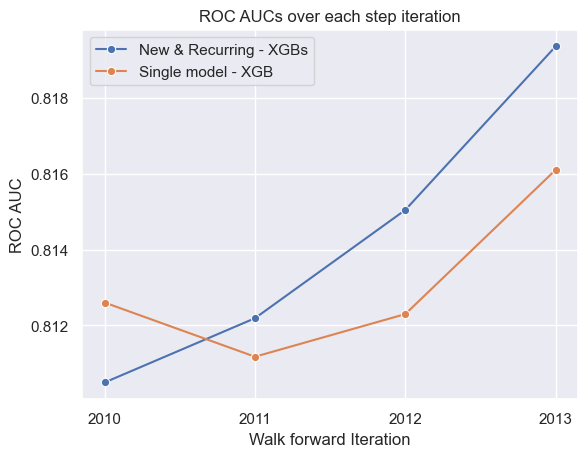

In [126]:
sns.lineplot(x=xgb_predictions['group'].unique().astype(int).astype(str), y=xgb_stats_list, marker="o",label='New & Recurring - XGBs')
sns.lineplot(x=xgb_2_predictions['group'].unique().astype(int).astype(str), y=xgb_2_stats_list, marker="o",label='Single model - XGB')
plt.title('ROC AUCs over each step iteration')
plt.xlabel('Walk forward Iteration')
plt.ylabel('ROC AUC')
plt.savefig('wf_results_new_rec.png')
plt.show()